# Import the package

In [2]:
from datetime import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import sort
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper,DeltaYStopper
from skopt.space import Real,Categorical,Integer
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import joblib

# Datasets

In [15]:
HDbi=pd.read_csv('Filled Binary HD.csv')
# ,index_col=0)
HDbi.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [17]:
X=HDbi.drop(labels=['label'],axis=1)

y=HDbi['label'].values

In [18]:
#stanardilization
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

In [19]:
#split train dataset and test dataset
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)



In [20]:
gbm =lgbm_params=LGBMClassifier(boosting_type='gbdt',max_depth=4, num_leaves=300,
                                learning_rate=0.01,n_estimators=150)


In [70]:

score =cross_val_score(gbm, X_train, y_train, cv=5,scoring='neg_log_loss').mean()
print('cross validation loss at trainingset:',score) 

gbm.fit(X_train, y_train)
prob_gbm=gbm.predict_proba(X_test)
loss_gbm=log_loss(y_test,prob_gbm)
print('gbm at testset accuracy:',gbm.score(X_test,y_test)) 
print('loss at testset annually calculated :',loss_gbm)  

cross validation loss at trainingset: -0.45425968224741853
gbm at testset accuracy: 0.8524590163934426
loss at testset annually calculated : 0.38229790242105466


# RFE

 ## Bayes OPT hyperparameter searching

In [71]:
start=datetime.now()

# Bayers搜索，参数优化
BayerLgbmopt = BayesSearchCV(
     gbm,
     {         
        'learning_rate': (0.005,0.01,0.001), 
        'n_estimators': (100,300), 
  
        'max_depth': (3,8), 
        'num_leaves':(8, 170),
         
        'subsample': (0.5,0.8), 
        'colsample_bytree': (0.5,0.8)
       
    } ,
     n_iter=50,
     cv=5
     ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)
BayerLgbmopt.fit(X_train, y_train)

stop=datetime.now()

execution_time_lgbm0=(stop-start)
print(execution_time_lgbm0)

0:00:41.757133


In [72]:
print('Best parameters found by Bayes search are:', BayerLgbmopt.best_params_)
print("val. score: %s" % BayerLgbmopt.best_score_)
print("test score: %s" % BayerLgbmopt.score(X_test, y_test))

Best parameters found by Bayes search are: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_depth', 8), ('n_estimators', 300), ('num_leaves', 8), ('subsample', 0.5)])
val. score: -0.40873240241410763
test score: -0.318809706288266


###  Build the modle with the OPT hyperparameter

In [169]:
lgbm=LGBMClassifier(boosting_type='gbdt',
                                 max_depth=8, num_leaves=8,
                                learning_rate=0.01,n_estimators=300,
                                colsample_bytree= 0.5,subsample= 0.5)

###  Feature selection with the OPT model

0.3780187547947218 10
[0.6242413537837662, 0.6274485247640864, 0.644779666972882, 0.5864913356908097, 0.5018230222278428, 0.433927882672278, 0.3944406634434669, 0.38055379883441587, 0.3819078800926734, 0.3780187547947218, 0.38764669393193374, 0.3846133604369906, 0.38842666271494614]


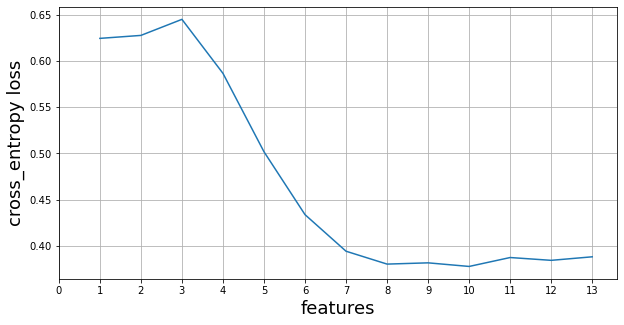

datetime.timedelta(seconds=5, microseconds=843968)

In [76]:
# 递归特征消除法和曲线图选取最优特征数量 
start=datetime.now()
score = []                                                            # 建立列表
for i in range(1,14, 1):
    X_wrapper=RFE(lgbm, n_features_to_select=i, step=1).fit_transform(X, y)      # 最优特征 
    once = cross_val_score(lgbm, X_wrapper, y, cv=5,scoring='neg_log_loss').mean()                      # 交叉验证
    score.append(once)                                                           # 交叉验证结果保存到列表
cross_entropy_loss=[j * -1 for j in score]

print(min(cross_entropy_loss), (cross_entropy_loss.index(min(cross_entropy_loss))*1)+1)                                 # 输出最优分类结果和对应的特征数量
print(cross_entropy_loss)
plt.figure(figsize=[10, 5])
plt.plot(range(1, 14, 1), cross_entropy_loss)
plt.xticks(range(0, 14))
plt.xlabel(u'features', fontsize=18)
plt.ylabel(u'cross_entropy loss', fontsize=18)
plt.grid()
plt.show()
stop=datetime.now()

execution_time_lgbm1=(stop-start)
execution_time_lgbm1

In [170]:
# 4.递归特征消除法
start=datetime.now()
selector = RFE(lgbm, n_features_to_select=10, step=1).fit(X, y)       # n_features_to_select表示筛选最终特征数量，step表示每次排除一个特征
selector.support_.sum()
print(selector.ranking_)                                             # 特征排除排序
print(selector.n_features_)                                          # 选择特征数量
X_wrapper_10 = selector.transform(X)                                   # 最优特征


stop=datetime.now()

execution_time_lgbm2=(stop-start)
execution_time_lgbm2

[1 1 1 2 1 4 1 1 1 1 3 1 1]
10


datetime.timedelta(microseconds=168925)

## Save the selected feature to csv file

In [172]:
index10=selector.get_support(indices=True)
index10

array([ 0,  1,  2,  4,  6,  7,  8,  9, 11, 12], dtype=int64)

In [173]:
idx=[  0,  1,  2,  4,  6,  7,  8,  9, 11, 12]
A=arrFilled01.iloc[ :,idx]
A['label'] = y
A

,age,sex,cp,chol,restecg,thalach,exang,oldpeak,ca,thal,label
0,63,1,1,233,2,150,0,2.3,0,6,0
1,67,1,4,286,2,108,1,1.5,3,3,1
2,67,1,4,229,2,129,1,2.6,2,7,1
3,37,1,3,250,0,187,0,3.5,0,3,0
4,41,0,2,204,2,172,0,1.4,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,264,0,132,0,1.2,0,7,1
299,68,1,4,193,0,141,0,3.4,2,7,1
300,57,1,4,131,0,115,1,1.2,1,7,1
301,57,0,2,236,2,174,0,0.0,1,3,1


In [174]:
A.to_csv('HD selected 10 features.csv',index=False)

# OPT

In [21]:
features10=pd.read_csv('HD selected 10 features.csv')
# ,index_col=0)
features10.head()

,age,sex,cp,chol,restecg,thalach,exang,oldpeak,ca,thal,label
0,63,1,1,233,2,150,0,2.3,0,6,0
1,67,1,4,286,2,108,1,1.5,3,3,1
2,67,1,4,229,2,129,1,2.6,2,7,1
3,37,1,3,250,0,187,0,3.5,0,3,0
4,41,0,2,204,2,172,0,1.4,0,3,0


In [22]:
X1=features10.drop(labels=['label'],axis=1)

y1=features10['label'].values

In [23]:
scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)
#split train dataset and test dataset


In [24]:
X1_train, X1_test, y1_train, y1_test =train_test_split(X1, y1,test_size=0.20, random_state=0, stratify=y1)

## Light GBM

In [281]:
lgbm.fit(X1_train, y1_train)

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.01, max_depth=8,
               n_estimators=300, num_leaves=8, subsample=0.5)

In [283]:
y_pred_lgbm1=lgbm.predict(X1_test)
y_prob_lgbm1=lgbm.predict_proba(X1_test)[:, 1]
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_lgbm1))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_lgbm1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_lgbm1))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_lgbm1))


Accuracy score with LGBM is:  0.8360655737704918
F1 score with LGBM is:  0.8360655737704918
ROC_AUC score with LGBM is:  0.9404761904761905
Cross entropy loss score with LGBM is:  0.3493712430687207


### 2nd OPT

In [267]:
start=datetime.now()

# Bayers搜索，参数优化
BayerLgbmopt1 = BayesSearchCV(
     lgbm,
     {         
        'learning_rate': (0.005,0.01,0.001), 
        'n_estimators': (100,300), 
  
        'max_depth': (3,8), 
        'num_leaves':(8, 170),
         
        'subsample': (0.5,0.8), 
        'colsample_bytree': (0.5,0.8)
       
    } ,
     n_iter=50,
     cv=5
     ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)
BayerLgbmopt1.fit(X1_train, y1_train)

stop=datetime.now()
execution_time_lgbm3=(stop-start)
print(execution_time_lgbm3)

0:00:43.957337


In [284]:
print('Best parameters found by Bayes search are:', BayerLgbmopt1.best_params_)
print("val. score: %s" % BayerLgbmopt1.best_score_)
print("test score: %s" % BayerLgbmopt1.score(X1_test, y1_test))

Best parameters found by Bayes search are: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_depth', 5), ('n_estimators', 300), ('num_leaves', 110), ('subsample', 0.5)])
val. score: -0.4053941766662098
test score: -0.7597034841906145


In [269]:
lgbm1=LGBMClassifier(boosting_type='gbdt',
                                 max_depth=8, num_leaves=8,
                                learning_rate=0.01,n_estimators=300,
                                colsample_bytree= 0.5,subsample= 0.5)

In [288]:
start=datetime.now()
lgbm_hd=lgbm1.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_lgbm4=(stop-start)

print(execution_time_lgbm4)

0:00:00.068968


In [272]:
# save the model
joblib.dump(lgbm_hd,'lgbm_hd.model')

['lgbm_hd.model']

In [273]:
   #加载模型
RFlgmb=joblib.load('lgbm_hd.model')
   #应用模型进行预测
resultlgmb=RFlgmb.score(X1_test,y1_test)

In [274]:
resultlgmb

0.8360655737704918

In [275]:
training_time_lgbm=execution_time_lgbm4.total_seconds()
training_time_lgbm='%.4f'%training_time_lgbm
print(training_time_lgbm)

0.0690


In [261]:


start=datetime.now()
accuracy_score_10 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_10 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_10 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_10 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_lgbm4=(stop-start)/20
execution_time_lgbm4

print("accuracy 10  feature:",accuracy_score_10)
print('F1 score 10  feature:',F1_score_10)
print('roc_auc 10  feature:',roc_auc_score_10)
print("cross entropy loss 10  feature:",neg_loss_score_10)

accuracy 10  feature: 0.8097789115646258
F1 score 10  feature: 0.8097789115646258
roc_auc 10  feature: 0.9022037543776674
cross entropy loss 10  feature: -0.405351906275797


In [262]:
execution_time_lgbm4

datetime.timedelta(microseconds=35592)

In [286]:
y_pred_lgbm1=lgbm1.predict((X1_test))
y_prob_lgbm1=lgbm1.predict_proba(X1_test)[:, 1]
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_lgbm1))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_lgbm1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_lgbm1))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_lgbm1))


Accuracy score with LGBM is:  0.8360655737704918
F1 score with LGBM is:  0.8360655737704918
ROC_AUC score with LGBM is:  0.9404761904761905
Cross entropy loss score with LGBM is:  0.3493712430687207


In [287]:
lgbm_accuracy='%.4f'%accuracy_score(y1_test, y_pred_lgbm1)
lgbm_f1='%.4f'%f1_score(y1_test, y_pred_lgbm1,average='micro')
lgbm_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_lgbm1)
lgbm_loss='%.4f'%log_loss(y1_test,y_prob_lgbm1)
print(lgbm_accuracy)
print(lgbm_f1)
print(lgbm_roc_auc)
print(lgbm_loss)

0.8361
0.8361
0.9405
0.3494


## SVM

In [3]:
HDbiSVM=pd.read_csv('Filled Binary HD.csv')
# ,index_col=0)
HDbiSVM.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [4]:
X_svm=HDbiSVM.drop(labels=['label'],axis=1)

y_svm=HDbiSVM['label'].values

In [5]:
X_svm_train, X_svm_test, y_svm_train, y_svm_test =train_test_split(X_svm, y_svm,test_size=0.20, random_state=0, stratify=y_svm)

In [6]:
svc= SVC(C=0.0165, degree=6, gamma=1.5836,
    kernel='linear', probability=True, random_state=42)

In [10]:
svc1= SVC(
  
           C= 8.5385
           ,kernel='rbf'
           ,degree= 7
          ,gamma="scale"
          , probability=True)
#     C=0.0165
#     , degree=6
#     , gamma=1.5836,
#      kernel='linear'
#     , probability=True, random_state=42)
accuracies = cross_val_score(svc1,X_svm_train,y_svm_train,cv=5)
loss=cross_val_score(svc1,X_svm_train,y_svm_train,cv=5,scoring='neg_log_loss')
svc1.fit(X_svm_train,y_svm_train)
pred=svc1.predict(X_svm_test)
prob=svc1.predict_proba(X_svm_test)
print("CVTrain loss Score:",np.mean(loss))
print("CVTrain accuracy Score:",np.mean(accuracies))
print("Test accuracy Score:",svc1.score(X_svm_test,y_svm_test))
print("Test loss Score:",log_loss(y_svm_test,prob))

CVTrain loss Score: -0.58731872474043
CVTrain accuracy Score: 0.7066326530612245
Test accuracy Score: 0.6557377049180327
Test loss Score: 0.5940428664987821


In [11]:
svc2= SVC(
    C=0.1
#     , degree=6
#     , gamma=1.5836,
     ,kernel='linear'
    , probability=True, random_state=42)
accuracies = cross_val_score(svc2,X_svm_train,y_svm_train,cv=5)
loss=cross_val_score(svc2,X_svm_train,y_svm_train,cv=5,scoring='neg_log_loss')
svc2.fit(X_svm_train,y_svm_train)
pred=svc2.predict(X_svm_test)
prob=svc2.predict_proba(X_svm_test)
print("CVTrain loss Score:",np.mean(loss))
print("CVTrain accuracy Score:",np.mean(accuracies))
print("Test accuracy Score:",svc2.score(X_svm_test,y_svm_test))
print("Test loss Score:",log_loss(y_svm_test,prob))

CVTrain loss Score: -0.4066639146306235
CVTrain accuracy Score: 0.8471088435374149
Test accuracy Score: 0.8524590163934426
Test loss Score: 0.32445087249902776


In [12]:
svc3= SVC(
#     C=0.0165
#     , degree=6
#     , gamma=1.5836,
     kernel='linear'
    , probability=True, random_state=42)
accuracies = cross_val_score(svc1,X_svm_train,y_svm_train,cv=5)
loss=cross_val_score(svc1,X_svm_train,y_svm_train,cv=5,scoring='neg_log_loss')
svc1.fit(X_svm_train,y_svm_train)
pred=svc1.predict(X_svm_test)
prob=svc1.predict_proba(X_svm_test)
print("CVTrain loss Score:",np.mean(loss))
print("CVTrain accuracy Score:",np.mean(accuracies))
print("Test accuracy Score:",svc1.score(X_svm_test,y_svm_test))
print("Test loss Score:",log_loss(y_svm_test,prob))

CVTrain loss Score: -0.5857523881918284
CVTrain accuracy Score: 0.7066326530612245
Test accuracy Score: 0.6557377049180327
Test loss Score: 0.5926080242650215


In [13]:
accuracies = cross_val_score(svc,X_svm_train,y_svm_train,cv=5)
loss=cross_val_score(svc,X_svm_train,y_svm_train,cv=5,scoring='neg_log_loss')
svc.fit(X_svm_train,y_svm_train)
pred=svc.predict(X_svm_test)
prob=svc.predict_proba(X_svm_test)
print("CVTrain loss Score:",np.mean(loss))
print("CVTrain accuracy Score:",np.mean(accuracies))
print("Test accuracy Score:",svc.score(X_svm_test,y_svm_test))
print("Test loss Score:",log_loss(y_svm_test,prob))

CVTrain loss Score: -0.42683653945525474
CVTrain accuracy Score: 0.8387755102040817
Test accuracy Score: 0.8852459016393442
Test loss Score: 0.3410396355819228


### BAYES OPT with whole training dataset 

In [8]:
start=datetime.now()

# log-uniform: understand as search over p = exp(x) by varying x
BayerSvmopt = BayesSearchCV(
    SVC(probability=True, random_state=42),
    {
        

#         'C':(0.01, 10),
        'kernel': ['linear', 'poly', 'rbf'],
#         'gamma': (0.01, 3),
#         'degree': (1, 10), 
    
    },
    n_iter=50,
    cv=5
    ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

BayerSvmopt.fit(X_svm_train, y_svm_train)

stop=datetime.now()

execution_time_svm1=(stop-start)
execution_time_svm1

datetime.timedelta(seconds=255, microseconds=423096)

In [10]:
print('Best parameters found by Bayes search are:', BayerSvmopt.best_params_)
print("val. score: %s" % BayerSvmopt.best_score_)
print("test score: %s" % BayerSvmopt.score(X_svm_test, y_svm_test))

Best parameters found by Bayes search are: OrderedDict([('kernel', 'linear')])
val. score: -0.415526724216598
test score: -0.32799933702589457


### BAYES OPT with selected feature training dataset

In [180]:
start=datetime.now()

# log-uniform: understand as search over p = exp(x) by varying x
BayerSvmopt1 = BayesSearchCV(
    svc2,
    {
        

        'C':[0.005,0.1, 0.2],
#         'kernel': ['linear', 'poly', 'rbf'],
#         'gamma': (0.01, 3),
#         'degree': (1, 10), 
    
    },
    n_iter=50,
    cv=5
    ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

BayerSvmopt1.fit(X1_train, y1_train)

stop=datetime.now()

execution_time_svm3=(stop-start)
execution_time_svm3

datetime.timedelta(seconds=48, microseconds=857657)

In [183]:
print('Best parameters found by Bayes search are:', BayerSvmopt1.best_params_)
print("val. score: %s" % BayerSvmopt1.best_score_)
print("test score: %s" % BayerSvmopt1.score(X1_test, y1_test))

Best parameters found by Bayes search are: OrderedDict([('C', 0.1)])
val. score: -0.40917235837765
test score: -0.3208693672251356


In [25]:
svc1.fit(X1_train,y1_train)
y_pred_svc1=svc1.predict(X1_test)
y_prob_svc1=svc1.predict_proba(X1_test)[:,1]
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_svc1))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_svc1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_svc1))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_svc1))

Accuracy score with LGBM is:  0.819672131147541
F1 score with LGBM is:  0.819672131147541
ROC_AUC score with LGBM is:  0.8755411255411256
Cross entropy loss score with LGBM is:  0.4378867655789415


In [26]:
svc2.fit(X1_train,y1_train)
y_pred_svc2=svc2.predict(X1_test)
y_prob_svc2=svc2.predict_proba(X1_test)[:,1]
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_svc2))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_svc2,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_svc2))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_svc2))


Accuracy score with LGBM is:  0.8524590163934426
F1 score with LGBM is:  0.8524590163934426
ROC_AUC score with LGBM is:  0.948051948051948
Cross entropy loss score with LGBM is:  0.32583070798834746


In [27]:

svc3.fit(X1_train,y1_train)
y_pred_svc3=svc3.predict(X1_test)
y_prob_svc3=svc3.predict_proba(X1_test)[:,1]
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_svc3))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_svc3,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_svc3))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_svc3))

Accuracy score with LGBM is:  0.8360655737704918
F1 score with LGBM is:  0.8360655737704918
ROC_AUC score with LGBM is:  0.9372294372294373
Cross entropy loss score with LGBM is:  0.35109781289475744


In [28]:
start=datetime.now()
accuracy_score_10_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_10_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_10_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_10_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_svm1=(stop-start)/20
execution_time_svm1

print("accuracy 10  feature:",accuracy_score_10_svm)
print('F1 score 10  feature:',F1_score_10_svm)
print('roc_auc 10  feature:',roc_auc_score_10_svm)
print("cross entropy loss 10  feature:",neg_loss_score_10_svm)


accuracy 10  feature: 0.8264455782312925
F1 score 10  feature: 0.8264455782312925
roc_auc 10  feature: 0.8744991723252593
cross entropy loss 10  feature: -0.43571142627404935


In [29]:
training_time_svm1=execution_time_svm1.total_seconds()
training_time_svm1='%.4f'%training_time_svm1
print(training_time_svm1)

0.0111


In [30]:
start=datetime.now()
accuracy_score_10_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_10_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_10_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_10_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_svm=(stop-start)/20
execution_time_svm

print("accuracy 10  feature:",accuracy_score_10_svm)
print('F1 score 10  feature:',F1_score_10_svm)
print('roc_auc 10  feature:',roc_auc_score_10_svm)
print("cross entropy loss 10  feature:",neg_loss_score_10_svm)

accuracy 10  feature: 0.8470238095238095
F1 score 10  feature: 0.8470238095238095
roc_auc 10  feature: 0.8961245678636983
cross entropy loss 10  feature: -0.4042797609932098


In [31]:
training_time_svm=execution_time_svm.total_seconds()
training_time_svm='%.4f'%training_time_svm
print(training_time_svm)

0.0066


In [32]:
svc1_accuracy='%.4f'%accuracy_score(y1_test, y_pred_svc1)
svc1_f1='%.4f'%f1_score(y1_test, y_pred_svc2,average='micro')
svc1_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_svc1)
svc1_loss='%.4f'%log_loss(y1_test,y_prob_svc1)
print(svc1_accuracy)
print(svc1_f1)
print(svc1_roc_auc)
print(svc1_loss)

0.8197
0.8525
0.8755
0.4379


In [33]:
svc_accuracy='%.4f'%accuracy_score(y1_test, y_pred_svc2)
svc_f1='%.4f'%f1_score(y1_test, y_pred_svc2,average='micro')
svc_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_svc2)
svc_loss='%.4f'%log_loss(y1_test,y_prob_svc2)
print(svc_accuracy)
print(svc_f1)
print(svc_roc_auc)
print(svc_loss)

0.8525
0.8525
0.9481
0.3258


In [34]:

start=datetime.now()
svc_hd1=svc1.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_svc0='%.4f'%(stop-start).total_seconds()

print(execution_time_svc0)

0.0156


In [35]:

start=datetime.now()
svc_hd=svc2.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_svc='%.4f'%(stop-start).total_seconds()

print(execution_time_svc)

0.0156


In [36]:
  #保存模型
joblib.dump(svc_hd,'svc_hd.model')

['svc_hd.model']

In [37]:
   #加载模型
RFsvc=joblib.load('svc_hd.model')
   #应用模型进行预测
resultsvc=RFsvc.score(X1_test,y1_test)

In [38]:
resultsvc

0.8524590163934426

# Random Forest

In [158]:
rf = RFC(random_state=42)


Bayesrfopt = BayesSearchCV(
   rf,
    {   
    'n_estimators': [50,100,150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,None],
    'criterion' :['gini', 'entropy']
    },
    n_iter=50,
    cv=5,
    scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

Bayesrfopt.fit(X_train, y_train)
print('Best parameters found by grid search are:', Bayesrfopt.best_params_)

Best parameters found by grid search are: OrderedDict([('criterion', 'entropy'), ('max_depth', 7), ('max_features', 'log2'), ('n_estimators', 150)])


In [181]:
print('Best parameters found by Bayes search are:', Bayesrfopt.best_params_)
print("val. score: %s" % Bayesrfopt.best_score_)
print("test score: %s" % Bayesrfopt.score(X_test, y_test))

Best parameters found by Bayes search are: OrderedDict([('criterion', 'entropy'), ('max_depth', 7), ('max_features', 'log2'), ('n_estimators', 150)])
val. score: -0.4197576300542467
test score: -0.33260774429243106


In [202]:
rf1 = RFC(random_state=42, max_features='log2', n_estimators= 150,
                                     max_depth=7, 
                                     criterion='entropy')

In [224]:
start=datetime.now()
rf1.fit(X_train,y_train)
stop=datetime.now()
execution_time_rf=(stop-start)
execution_time_rf
training_time_rf0=execution_time_rf.total_seconds()
training_time_rf0='%.4f'%training_time_rf0
print(training_time_rf0)

0.1848


In [204]:
accuracies = cross_val_score(rf1,X_svm_train,y_svm_train,cv=5)
loss=cross_val_score(rf1,X_svm_train,y_svm_train,cv=5,scoring='neg_log_loss')
rf1.fit(X_train,y_train)
pred=rf1.predict(X_test)
prob=rf1.predict_proba(X_test)
print("CVTrain loss Score:",np.mean(loss))
print("CVTrain accuracy Score:",np.mean(accuracies))
print("Test accuracy Score:",rf1.score(X_test,y_test))
print("Test loss Score:",log_loss(y_test,prob))

CVTrain loss Score: -0.4191617780173858
CVTrain accuracy Score: 0.8139455782312925
Test accuracy Score: 0.8852459016393442
Test loss Score: 0.332607744292431


In [212]:
start=datetime.now()
Bayesrfopt1 = BayesSearchCV(
   rf1,
    {   
    'n_estimators': [50,100,150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,None],
    'criterion' :['gini', 'entropy']
    },
    n_iter=50,
    cv=5,
    scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

Bayesrfopt1.fit(X1_train, y1_train)

stop=datetime.now()
execution_time_rf0=(stop-start)
print(execution_time_rf0)
print('Best parameters found by grid search are:', Bayesrfopt1.best_params_)

0:01:18.440512
Best parameters found by grid search are: OrderedDict([('criterion', 'entropy'), ('max_depth', 7), ('max_features', 'sqrt'), ('n_estimators', 100)])


In [214]:
print('Best parameters found by Bayes search are:', Bayesrfopt1.best_params_)
print("val. score: %s" % Bayesrfopt1.best_score_)
print("test score: %s" % Bayesrfopt1.score(X1_test, y1_test))

Best parameters found by Bayes search are: OrderedDict([('criterion', 'entropy'), ('max_depth', 7), ('max_features', 'sqrt'), ('n_estimators', 100)])
val. score: -0.3971214870694783
test score: -0.3606421650658817


In [206]:
rf2= RFC(random_state=42, max_features='sqrt', n_estimators= 100,
                                     max_depth=7, 
                                     criterion='entropy')


In [227]:
start=datetime.now()
accuracy_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_rf=(stop-start)/20
execution_time_rf

print("accuracy 10  feature:",accuracy_score_10_rf)
print('F1 score 10  feature:',F1_score_10_rf)
print('roc_auc 10  feature:',roc_auc_score_10_rf)
print("cross entropy loss 10  feature:",neg_loss_score_10_rf)

accuracy 10  feature: 0.8141156462585034
F1 score 10  feature: 0.8141156462585034
roc_auc 10  feature: 0.8990242446764187
cross entropy loss 10  feature: -0.3971214870694783


In [297]:
training_time_rf=execution_time_rf.total_seconds()
training_time_rf='%.4f'%training_time_rf
print(training_time_rf)

0.1173


In [237]:
rf_hd=rf2.fit(X1_train,y1_train)
y_pred_rf2=rf2.predict(X1_test)
y_prob_rf2=rf2.predict_proba(X1_test)[:,1]
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_rf2))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_rf2,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_rf2))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_rf2))


rf_accuracy='%.4f'%accuracy_score(y1_test, y_pred_rf2)
rf_f1='%.4f'%f1_score(y1_test, y_pred_rf2,average='micro')
rf_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_rf2)
rf_loss='%.4f'%log_loss(y1_test,y_prob_rf2)
print(rf_accuracy)
print(rf_f1)
print(rf_roc_auc)
print(rf_loss)

Accuracy score with LGBM is:  0.8852459016393442
F1 score with LGBM is:  0.8852459016393442
ROC_AUC score with LGBM is:  0.9307359307359306
Cross entropy loss score with LGBM is:  0.3606421650658817
0.8852
0.8852
0.9307
0.3606


In [245]:
# save the model
joblib.dump(rf_hd,'rf_hd.model')

['rf_hd.model']

In [250]:
   #加载模型
RFrf=joblib.load('rf_hd.model')
   #应用模型进行预测
rfresult=RFrf.score(X1_test,y1_test)

In [251]:
rfresult

0.8852459016393442